In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pickle
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
MODEL_FOLDER = "./m_stat_models/"

In [3]:
!rm -rf $MODEL_FOLDER
!mkdir  $MODEL_FOLDER

In [4]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [5]:
def get_AR_model(training_set, test_set, days, y_test):
    
    predictions = np.array([])

    for i in range(0, days):
        model = AutoReg(endog=training_set[:,target_column_idx], 
                        exog=training_set[:, target_column_idx+1:], 
                        lags=5)
        model_fit = model.fit()        
        prediction = model_fit.predict(start=len(training_set), 
                                       end=len(training_set),
                                       exog_oos=test_set[i, target_column_idx+1:].reshape(1,-1))
        predictions = np.append(predictions, prediction)
        training_set = np.vstack([training_set, test_set[i]])

    score = {
        "r2_score": r2_score(y_test, predictions),
        "mae": mean_absolute_error(y_test, predictions), 
        "rmse": np.sqrt(mean_squared_error(y_test, predictions)),
        "mean": np.mean(predictions)
    }

    return model_fit, score, None, predictions 

def get_ARIMA_model(training_set, test_set, days, y_test):
    
    predictions = np.array([])
    
    for i in range(0, days):
        model = SARIMAX(endog=training_set[:,target_column_idx], 
                        exog=training_set[:, target_column_idx+1:], 
                        order=(1,1,1), lags=5)
        model_fit = model.fit()        
        prediction = model_fit.predict(start=len(training_set), 
                                       end=len(training_set),
                                       exog=test_set[i, target_column_idx+1:])
        predictions = np.append(predictions, prediction)
        training_set = np.vstack([training_set, test_set[i]])

    score = {
        "r2_score": r2_score(y_test, predictions),
        "mae": mean_absolute_error(y_test, predictions), 
        "rmse": np.sqrt(mean_squared_error(y_test, predictions)),
        "mean": np.mean(predictions)
    }

    return model_fit, score, None, predictions 

In [6]:
MODEL_LIST = [
    ('ARX', get_AR_model),
    ('ARIMAX', get_ARIMA_model)
]

In [7]:
plt.rc('text', usetex=True)  
plt.rc('font', family='sans-serif')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

def line_format(label):
    if (label.day % 15 == 0):
        return f"{label.day}\n{label.month_name()[:3]}"

def perform_modelling(training_set, test_set, test_idx_values, 
                      dataset_name, target_column, show_graph=True):
    
    days = len(test_idx_values)
    y_test = test_set[:,target_column_idx]
    
    best = {}
    best_score = 9e9

    rows = []

    predictions = {}
    predictions['Actual'] = y_test.reshape(-1)

    for name, model_fn in MODEL_LIST:
        details = {}
        regressor, score, scaler, y_pred = model_fn(training_set, test_set, days, y_test)
        row = [f"{name} Regression", score['mae'], score['rmse'], score['r2_score'], score['mean']]
        rows.append(row)

        predictions[name + ""] = y_pred.reshape(-1)
            
        details['station_name'] = "1"
        details['station_id'] = "1"
        details['name'] = name + ""
        details['regressor'] = regressor
        details['scaler'] = scaler
        details['score'] = score       
        details['test_set_predictions'] = y_pred
        details['test_set'] = y_test          
        
        with open(MODEL_FOLDER + f"{dataset_name}/{name}/001.pkl", "wb") as file:
            pickle.dump(details, file, protocol=4)

        if score['rmse'] < best_score:
            best = details
            best_score = score['rmse']

    model_dfs = pd.DataFrame(rows, columns=["model", "mae", "rmse", "r2_score", "mean"])
    
    test_idx_values += datetime.timedelta(days=1)
    predictions_df = pd.DataFrame(predictions, index=test_idx_values)
    predictions_df.to_pickle(MODEL_FOLDER + f"{dataset_name}/001_predictions.pkl")
    
    if show_graph:
        fig = plt.figure(figsize=(18, 4))
        ax = fig.gca()
        
        predictions_df[['Actual', best['name']]].plot(ax=fig.gca())
        
        if dataset_name == 'beijing_pm25': dataset_name = "Beijing PM2.5"
        elif dataset_name == 'beijing_pm10': dataset_name = "Beijing PM10"  
        else: dataset_name = dataset_name.replace('_', ' ').title()
        
        plt.title(f"{dataset_name} | Test Set", fontsize=14)
        plt.ylabel(f'{target_column}')
#         plt.grid(ls='--')
        
        msg_rmse = f"RMSE: {best['score']['rmse'].round(3)}"
        msg_mae =  f"MAE:  {best['score']['mae'].round(3)}"
        msg_mean = f"MEAN: {best['score']['mean'].round(3)}"
        
        msg = msg_rmse + '\n' + msg_mae + '\n' + msg_mean 
        
        ax.set_xticks(predictions_df.index)
        ax.set_xticklabels(map(line_format, predictions_df.index), rotation=0,  ha="center");
        
        ax.text(0.475, 0.85, msg,
             bbox=dict(facecolor='white', alpha=1),
             horizontalalignment='left',
             verticalalignment='center',
             fontsize=12,
             transform=ax.transAxes)

    return best, model_dfs, predictions_df, ax   

In [8]:
import multiprocessing as mp

manager = mp.Manager()
ax_list = manager.list()

def perform_task(dataset, target_column, dataset_name):
    
    ratio = 0.3

    length = len(dataset)
    limit = (int)(ratio * length)

    training_set, test_set = dataset.values[:-limit], dataset.values[-limit:]
    test_idx_values = dataset.index.to_pydatetime()[-limit:]

    best, model_dfs, predictions_df, ax = perform_modelling(training_set, test_set, test_idx_values,
                                                            dataset_name, target_column, show_graph=True)
    
    ax_list.append(ax)

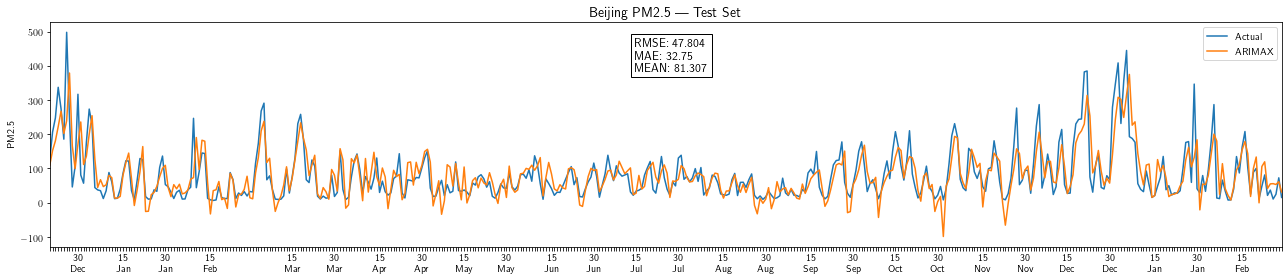

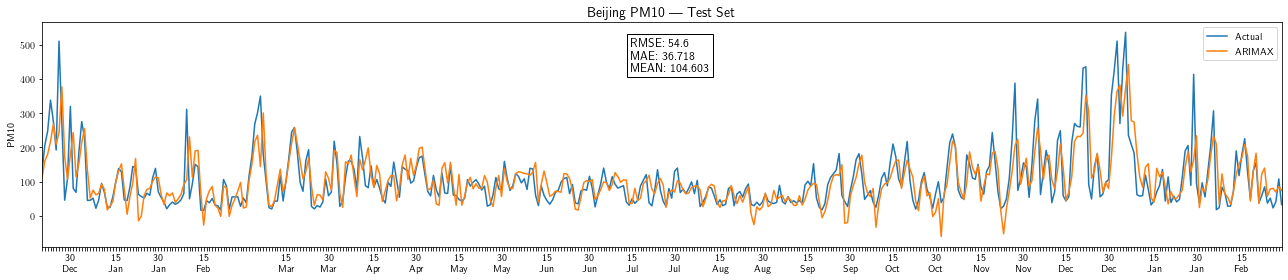

In [9]:
import os

datasets = [("beijing_pm25", "PM2.5"),
            ("beijing_pm10", "PM10")]

for dataset_name, target_column in datasets:

    try:
        os.mkdir(MODEL_FOLDER + dataset_name)               
    except:
        pass
    
    dataset = pickle.load(open(f"./Data/{dataset_name}_dataset.pkl", "rb"))
    target_column_idx = list(dataset.columns).index(target_column)

    if target_column_idx != 0:
        arrangement = [target_column] + list(dataset.columns[:target_column_idx]) + \
                      list(dataset.columns[target_column_idx+1:])
        dataset = dataset[arrangement]
    
    try:
        for name, model_fn in MODEL_LIST:
            os.mkdir(MODEL_FOLDER + f"{dataset_name}/{name}")
    except:
        pass

    perform_task(dataset, target_column, dataset_name)